## FRAUD DETECTION

In this project, we will analyze the Credit Card Transaction Dataset and develop fraud detection models using Random Forest and XGBoost.  

Dataset Overview:
- id: Unique identifier for each transaction.  
- V1–V28: Anonymized features representing various transaction attributes (e.g., time, location, etc.).  
- Amount: The monetary value of the transaction.  
- Class: Binary label indicating whether a transaction is fraudulent (1) or legitimate (0).

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import *
from xgboost import XGBClassifier
import joblib
from sklearn.pipeline import Pipeline

#### DATA EXPLORATION

In [3]:
data=pd.read_csv("C:/Users/Zenbook/Downloads/ds_test_2025_05_files/data.csv")
data.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,138028,1.088324,-0.252963,0.218284,-0.322955,0.377930,-0.210255,0.576307,-0.216568,0.417078,0.371406,-0.820867,0.488532,0.162543,0.262963,1.131177,0.900164,0.675997,0.525414,-0.332252,-0.222604,-0.172196,-0.426297,-0.165525,-0.332368,0.990322,0.868178,-0.276702,-0.023494,17540.44,0
1,63099,-0.101252,-0.074360,1.014615,-0.331446,0.342435,0.289295,0.618740,-0.120689,0.084854,0.673624,-0.181830,0.968114,0.017912,1.065049,0.368036,0.458494,0.290270,0.877323,0.491072,-0.246587,-0.022928,0.510293,-0.116590,0.063174,-0.478059,-0.919027,-0.657586,-0.373487,504.92,0
2,73411,0.038280,-0.530361,1.176422,-1.366641,0.029820,0.480989,0.219695,-0.158645,-0.709901,1.790807,-0.296292,0.303852,1.189517,0.536884,0.683633,0.089158,0.636912,1.149710,1.452172,-0.095957,-0.157171,0.065838,-0.215458,-0.828908,-0.577586,0.033296,-0.044742,0.477941,8075.44,0
3,164247,0.174719,-0.109529,0.118822,-0.640229,0.324553,-0.354105,0.736615,-0.121707,0.406979,0.168520,-1.218379,0.307193,-0.723035,0.494280,0.847544,0.641468,0.706078,1.054420,-0.379506,-0.338247,0.036824,0.840588,-0.042448,-0.198675,-0.624764,-0.339986,-0.264655,0.002212,14733.69,0
4,148999,1.582611,-0.321455,0.612570,0.649210,0.288382,1.001477,0.214045,-0.098299,0.951044,1.207239,0.018744,-0.149856,1.981040,1.691332,-1.966502,1.581696,0.307745,0.950332,-1.760656,-0.456558,-0.061885,0.552161,0.178368,1.495875,-0.414941,-0.034361,-0.260346,-0.203390,9339.27,0


In [4]:
data.tail()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
19995,502591,-1.395990,1.163603,-1.557164,1.597836,-1.679058,-1.996177,-1.695131,1.496193,-1.420722,-2.025023,1.722406,-1.798253,0.417730,-1.712649,-0.327265,-1.994921,-1.955364,-1.929174,2.353389,-0.411321,0.785062,0.075278,-0.617890,0.990619,0.454623,0.037686,-0.758808,-0.735353,23271.91,1
19996,523239,-2.157789,2.506679,-2.113256,1.199464,-2.542911,-2.465492,-2.031636,3.832314,-1.182053,-1.320239,1.288546,-1.155643,0.376923,-1.099159,-0.050681,-1.330970,-1.508648,-1.470727,0.750356,1.373166,0.553477,-1.277143,-0.843356,0.280285,2.329299,-0.520709,2.046643,1.032776,22482.40,1
19997,546599,-1.020201,-1.183700,-0.746335,-0.029270,0.009080,-0.511034,0.468194,-0.015243,-0.208425,-0.367792,-0.527203,-0.444083,-0.017666,-0.129358,-0.002398,-0.441953,-0.475839,-0.487173,0.389706,-1.654485,0.018910,0.762065,0.121167,0.266016,0.794876,0.417373,-0.030666,-0.100083,3862.00,1
19998,346662,-1.912969,1.842430,-2.127359,2.346142,-1.714635,-1.083535,-2.131717,0.160008,-1.916830,-1.898799,2.117881,-1.700333,0.914984,-1.645431,-0.439734,-1.482760,-1.360425,-1.431061,0.303634,0.814471,-1.128859,0.946451,1.246671,-1.703282,-0.165397,1.378106,3.018470,-3.560811,797.95,1
19999,493768,-0.707157,0.671107,-1.161978,0.864949,-1.303368,1.078292,-0.529125,0.640942,-0.922152,-1.321903,1.241098,-1.343793,-0.043130,-1.193735,0.049459,-1.387402,-1.280961,-1.484191,0.321600,-0.325583,0.421646,0.611989,0.888186,-1.061801,-2.621647,0.318344,0.979855,0.295146,10147.65,1


In [5]:
data.shape

(20000, 31)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      20000 non-null  int64  
 1   V1      20000 non-null  float64
 2   V2      20000 non-null  float64
 3   V3      20000 non-null  float64
 4   V4      20000 non-null  float64
 5   V5      20000 non-null  float64
 6   V6      20000 non-null  float64
 7   V7      20000 non-null  float64
 8   V8      20000 non-null  float64
 9   V9      20000 non-null  float64
 10  V10     20000 non-null  float64
 11  V11     20000 non-null  float64
 12  V12     20000 non-null  float64
 13  V13     20000 non-null  float64
 14  V14     20000 non-null  float64
 15  V15     20000 non-null  float64
 16  V16     20000 non-null  float64
 17  V17     20000 non-null  float64
 18  V18     20000 non-null  float64
 19  V19     20000 non-null  float64
 20  V20     20000 non-null  float64
 21  V21     20000 non-null  float64
 22

In [7]:
data.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing data

In [8]:
df=data.drop(['id'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.088324,-0.252963,0.218284,-0.322955,0.377930,-0.210255,0.576307,-0.216568,0.417078,0.371406,-0.820867,0.488532,0.162543,0.262963,1.131177,0.900164,0.675997,0.525414,-0.332252,-0.222604,-0.172196,-0.426297,-0.165525,-0.332368,0.990322,0.868178,-0.276702,-0.023494,17540.44,0
1,-0.101252,-0.074360,1.014615,-0.331446,0.342435,0.289295,0.618740,-0.120689,0.084854,0.673624,-0.181830,0.968114,0.017912,1.065049,0.368036,0.458494,0.290270,0.877323,0.491072,-0.246587,-0.022928,0.510293,-0.116590,0.063174,-0.478059,-0.919027,-0.657586,-0.373487,504.92,0
2,0.038280,-0.530361,1.176422,-1.366641,0.029820,0.480989,0.219695,-0.158645,-0.709901,1.790807,-0.296292,0.303852,1.189517,0.536884,0.683633,0.089158,0.636912,1.149710,1.452172,-0.095957,-0.157171,0.065838,-0.215458,-0.828908,-0.577586,0.033296,-0.044742,0.477941,8075.44,0
3,0.174719,-0.109529,0.118822,-0.640229,0.324553,-0.354105,0.736615,-0.121707,0.406979,0.168520,-1.218379,0.307193,-0.723035,0.494280,0.847544,0.641468,0.706078,1.054420,-0.379506,-0.338247,0.036824,0.840588,-0.042448,-0.198675,-0.624764,-0.339986,-0.264655,0.002212,14733.69,0
4,1.582611,-0.321455,0.612570,0.649210,0.288382,1.001477,0.214045,-0.098299,0.951044,1.207239,0.018744,-0.149856,1.981040,1.691332,-1.966502,1.581696,0.307745,0.950332,-1.760656,-0.456558,-0.061885,0.552161,0.178368,1.495875,-0.414941,-0.034361,-0.260346,-0.203390,9339.27,0


In [9]:
df.duplicated().any()

False

There is no duplicated data

In [10]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-0.004043,-0.000495,-0.005780,-0.000670,0.005055,-0.003906,-0.001927,0.007203,0.008168,0.006460,-0.001448,0.006336,-0.003249,0.001991,0.002031,-0.001074,0.007450,0.004525,0.005981,-0.001841,-0.001780,-0.002533,-0.000346,0.000382,-0.006619,-0.003544,0.007587,0.000722,12077.967842,0.500000
std,1.001815,0.991705,0.994902,0.998396,1.018205,1.008642,0.933962,1.017376,1.004726,1.004158,0.993691,0.999805,1.001064,0.994187,1.002230,0.992478,1.004188,1.005394,0.993602,0.997074,1.018253,1.007166,1.011365,1.011431,1.009899,0.996855,0.987139,0.988226,6869.127128,0.500013
min,-2.636567,-19.464020,-2.517353,-4.116263,-3.299790,-13.044546,-4.340630,-6.513701,-3.743306,-3.161891,-4.023502,-2.018488,-3.698844,-2.103413,-3.834486,-2.204652,-2.463367,-2.419422,-4.592047,-27.602574,-12.109795,-6.450353,-14.026056,-4.067968,-6.596943,-4.378342,-4.947034,-20.848764,50.480000,0.000000
25%,-0.573453,-0.484605,-0.648184,-0.657612,-0.291663,-0.457751,-0.284630,-0.191754,-0.564688,-0.590508,-0.690163,-0.823794,-0.697064,-0.867748,-0.628027,-0.708223,-0.605721,-0.557696,-0.558078,-0.353509,-0.165676,-0.487758,-0.241075,-0.649504,-0.559018,-0.641085,-0.302397,-0.230697,6189.177500,0.000000
50%,-0.093507,-0.136507,-0.003561,-0.074388,0.085448,0.078007,0.232076,-0.114247,0.097649,0.263944,-0.042566,0.161793,0.010479,0.227819,-0.035871,0.131636,0.273337,0.091067,-0.024734,-0.129498,-0.038868,-0.033004,-0.060102,0.017333,-0.015926,-0.011637,-0.170656,-0.014205,12121.010000,0.500000
75%,0.831516,0.342886,0.622557,0.705445,0.448814,0.493832,0.526529,0.047885,0.563516,0.594387,0.739107,0.754311,0.678445,0.752075,0.674296,0.645332,0.524192,0.544858,0.567616,0.238083,0.148858,0.452682,0.156921,0.697604,0.547549,0.666769,0.336191,0.417153,17979.752500,1.000000
max,2.164795,4.353545,3.989589,2.392356,32.538681,7.054983,13.492679,5.952470,8.751632,12.275958,2.509257,6.523728,3.624893,7.430410,5.479863,5.091365,6.313605,5.425492,3.482920,10.882094,8.087080,9.739887,21.034166,11.035900,10.458350,4.775370,22.915024,35.545563,24039.470000,1.000000


Features are measured on different scales; therefore, it is necessary to scale the data before training the model.

In [11]:
corr_matrix=df.corr()
corr_matrix

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,1.000000,-0.569704,0.490892,-0.497106,0.510240,0.361922,0.620895,-0.235413,0.541666,0.590551,-0.522097,0.576506,-0.029976,0.497412,0.043038,0.628860,0.605920,0.576568,-0.383913,-0.229169,-0.030829,-0.070827,-0.069652,-0.018985,-0.015689,0.018511,-0.140035,0.067749,0.004927,-0.505237
V2,-0.569704,1.000000,-0.642619,0.584710,-0.645480,-0.335379,-0.721344,0.199081,-0.583036,-0.619248,0.566915,-0.577920,0.014609,-0.524976,-0.149261,-0.528564,-0.494165,-0.484494,0.203419,0.286307,-0.022147,0.028818,0.131323,-0.016891,0.133254,0.003679,0.054149,0.058837,0.012497,0.493661
V3,0.490892,-0.642619,1.000000,-0.683061,0.510843,0.506433,0.681353,-0.269662,0.640913,0.697896,-0.691189,0.708517,-0.010819,0.673195,0.091174,0.610916,0.573167,0.517790,-0.306149,-0.262841,-0.019422,-0.040497,-0.056119,0.078036,-0.074674,-0.048948,-0.203865,0.004626,-0.007305,-0.680322
V4,-0.497106,0.584710,-0.683061,1.000000,-0.423028,-0.471095,-0.631026,0.200031,-0.671415,-0.707120,0.709799,-0.722261,0.002867,-0.715417,-0.091751,-0.588934,-0.523896,-0.474356,0.271292,0.254991,-0.017119,0.090887,0.046944,-0.105757,0.036684,0.133333,0.193340,-0.016577,0.013090,0.737611
V5,0.510240,-0.645480,0.510843,-0.423028,1.000000,0.237097,0.631623,-0.320029,0.472647,0.557420,-0.438871,0.472669,-0.119022,0.384412,0.062522,0.597829,0.667281,0.644223,-0.433491,-0.253742,0.035551,-0.109991,-0.115464,-0.090939,-0.059878,0.052589,-0.045587,0.082563,-0.010874,-0.337411
V6,0.361922,-0.335379,0.506433,-0.471095,0.237097,1.000000,0.423754,-0.610277,0.422665,0.463337,-0.493615,0.494781,-0.123382,0.503020,-0.037728,0.415410,0.376168,0.322704,-0.238665,-0.170848,-0.054376,0.052779,0.314986,-0.003855,-0.198666,-0.062760,-0.286794,-0.053654,-0.000544,-0.432314
V7,0.620895,-0.721344,0.681353,-0.631026,0.631623,0.423754,1.000000,-0.197654,0.635460,0.721315,-0.631464,0.642670,-0.036563,0.572194,0.122910,0.692319,0.700972,0.667924,-0.401960,-0.281803,0.035580,-0.107278,-0.103696,-0.016612,-0.007336,-0.003203,-0.106854,0.059029,-0.007172,-0.525314
V8,-0.235413,0.199081,-0.269662,0.200031,-0.320029,-0.610277,-0.197654,1.000000,-0.206558,-0.199525,0.227762,-0.214970,0.282892,-0.224148,0.105571,-0.236943,-0.282613,-0.255443,0.257257,0.121098,0.080077,-0.124189,-0.466409,0.085348,0.337401,0.038511,0.314094,0.052899,0.009419,0.147502
V9,0.541666,-0.583036,0.640913,-0.671415,0.472647,0.422665,0.635460,-0.206558,1.000000,0.748878,-0.629003,0.662265,-0.002000,0.628162,0.102498,0.565772,0.572842,0.513833,-0.291866,-0.322330,0.133836,-0.205789,-0.044136,0.044478,-0.033402,-0.131224,-0.110412,0.066542,-0.013112,-0.583614
V10,0.590551,-0.619248,0.697896,-0.707120,0.557420,0.463337,0.721315,-0.199525,0.748878,1.000000,-0.707712,0.732362,-0.020799,0.693799,0.097792,0.680593,0.644330,0.588334,-0.374622,-0.283126,0.039722,-0.150036,-0.055485,0.046023,-0.013337,-0.050387,-0.134962,0.042079,-0.008096,-0.668286


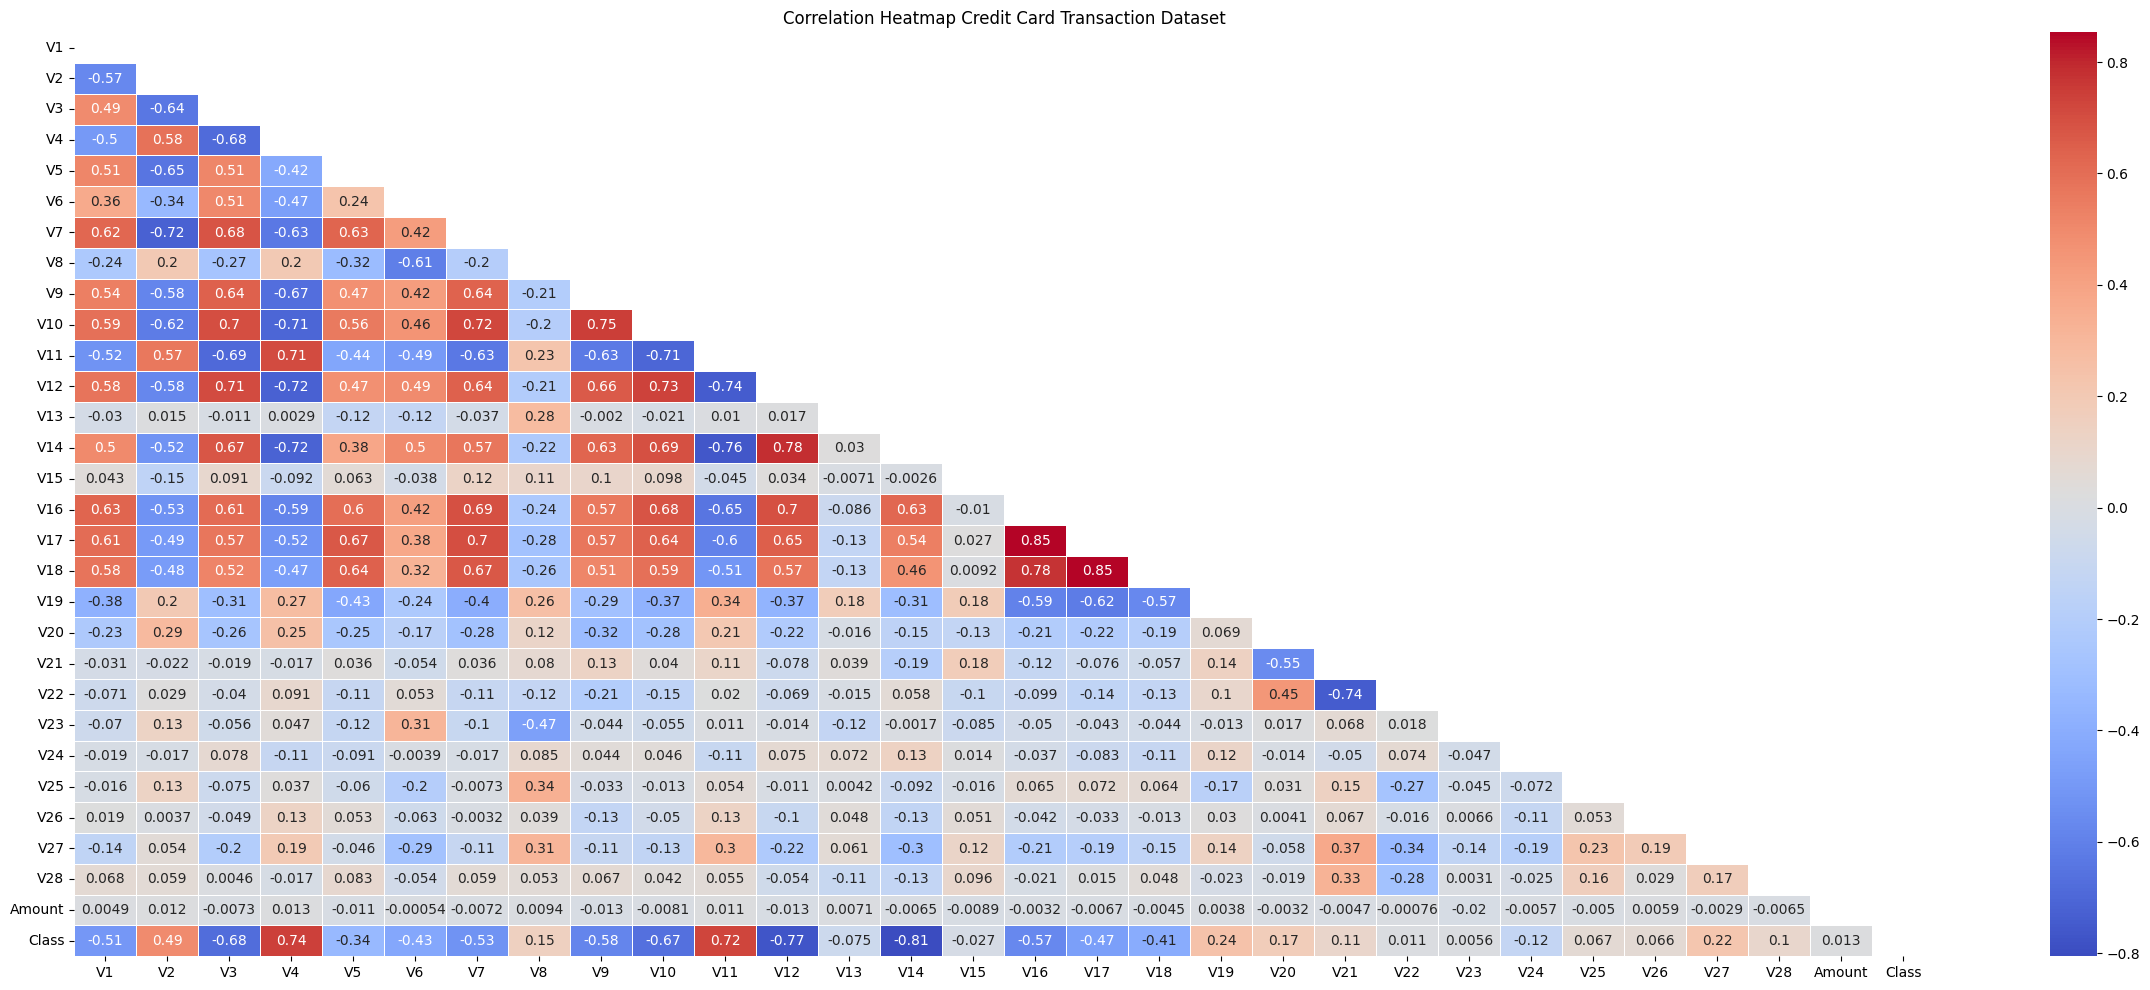

In [11]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(30, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap Credit Card Transaction Dataset')
plt.show()

In [12]:
corr_matrix['Class'].sort_values(ascending=False)

Class     1.000000
V4        0.737611
V11       0.723912
V2        0.493661
V19       0.238967
V27       0.220611
V20       0.174487
V8        0.147502
V21       0.106937
V28       0.101568
V25       0.066750
V26       0.066020
Amount    0.012551
V22       0.010538
V23       0.005598
V15      -0.027268
V13      -0.075383
V24      -0.124834
V5       -0.337411
V18      -0.406855
V6       -0.432314
V17      -0.472284
V1       -0.505237
V7       -0.525314
V16      -0.570009
V9       -0.583614
V10      -0.668286
V3       -0.680322
V12      -0.770043
V14      -0.805296
Name: Class, dtype: float64

*Class* variable has a strong positive correlation with variables *V4, V11* and a negative correlation with variables *V3, V10, V12, V14*. The remaining variables have a moderate to weak correlation.

#### DATA PREPROCESSING

Let's explore the distribution and outliers of each features

Histplot & Boxplot of V1


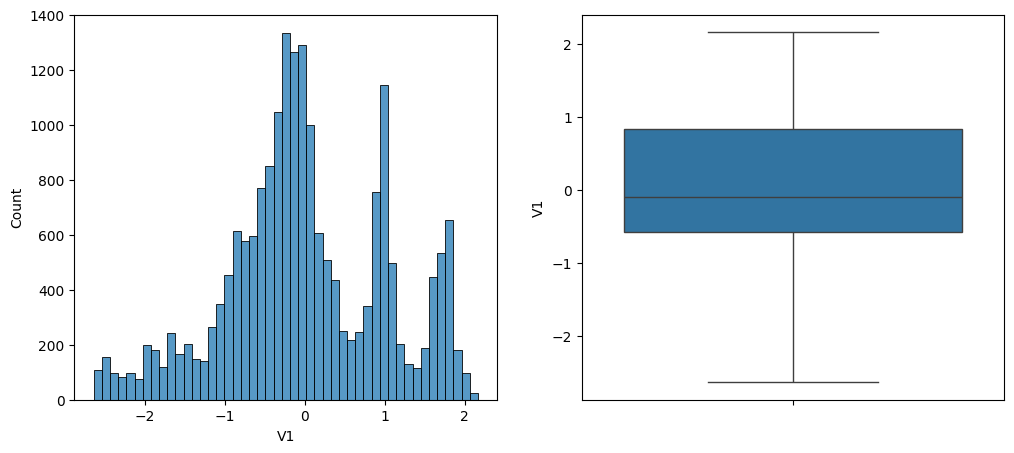

Histplot & Boxplot of V2


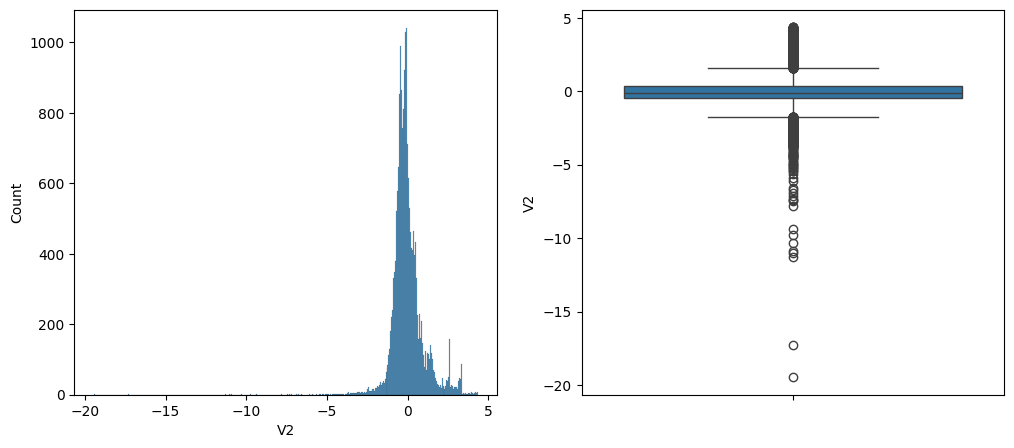

Histplot & Boxplot of V3


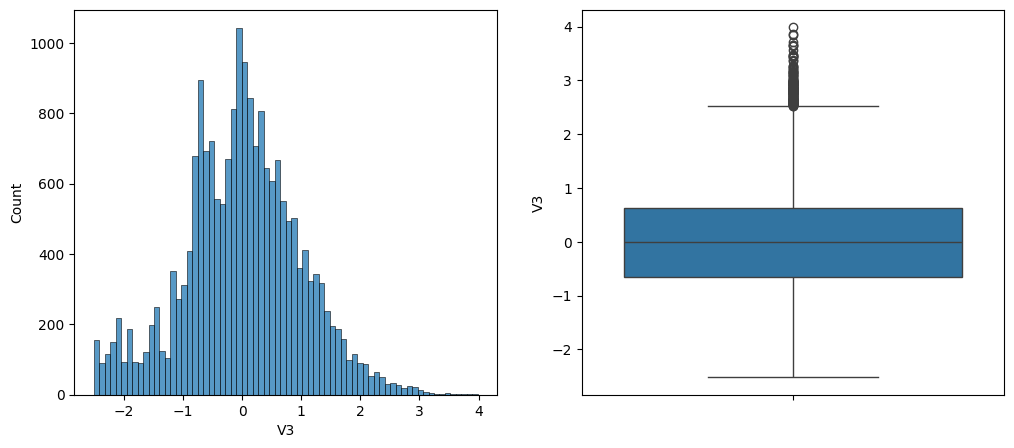

Histplot & Boxplot of V4


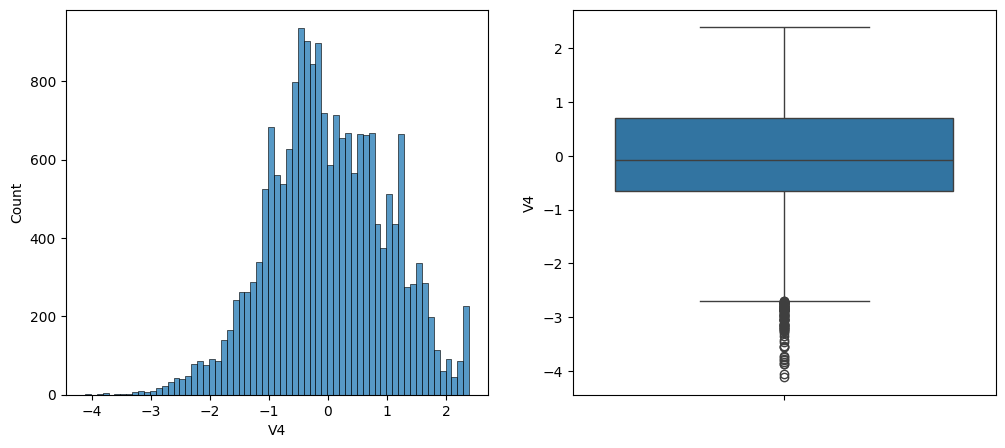

Histplot & Boxplot of V5


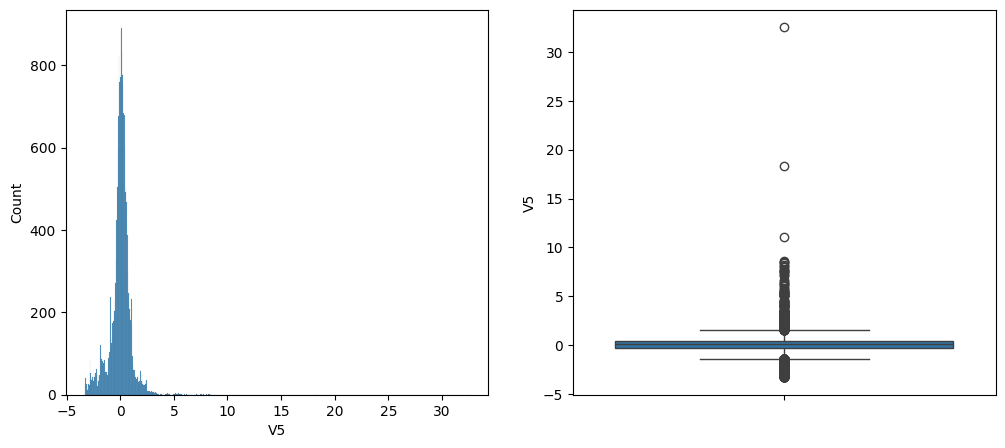

Histplot & Boxplot of V6


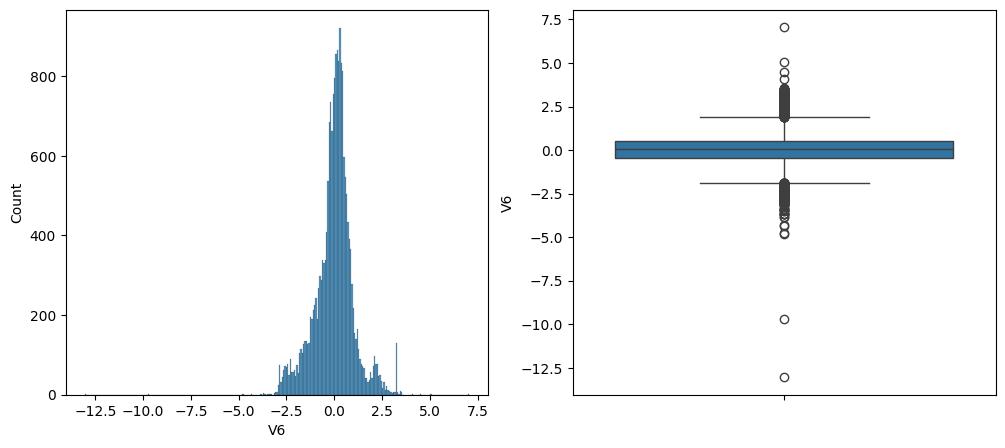

Histplot & Boxplot of V7


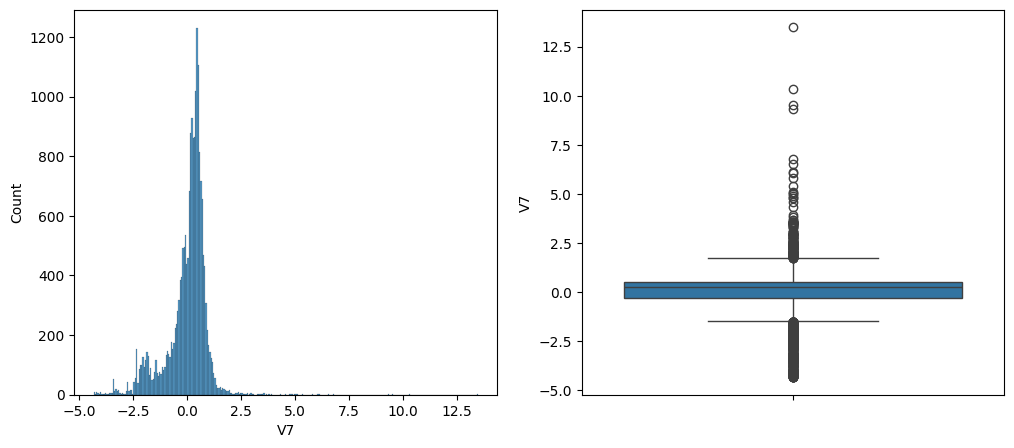

Histplot & Boxplot of V8


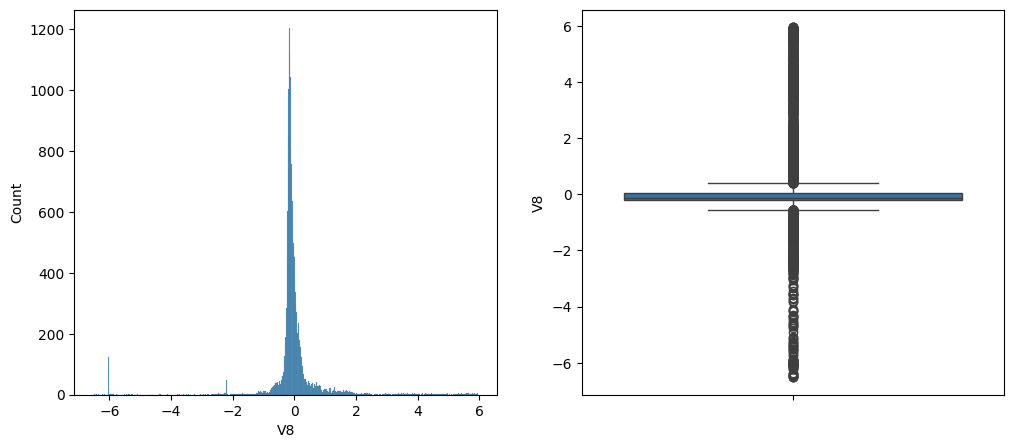

Histplot & Boxplot of V9


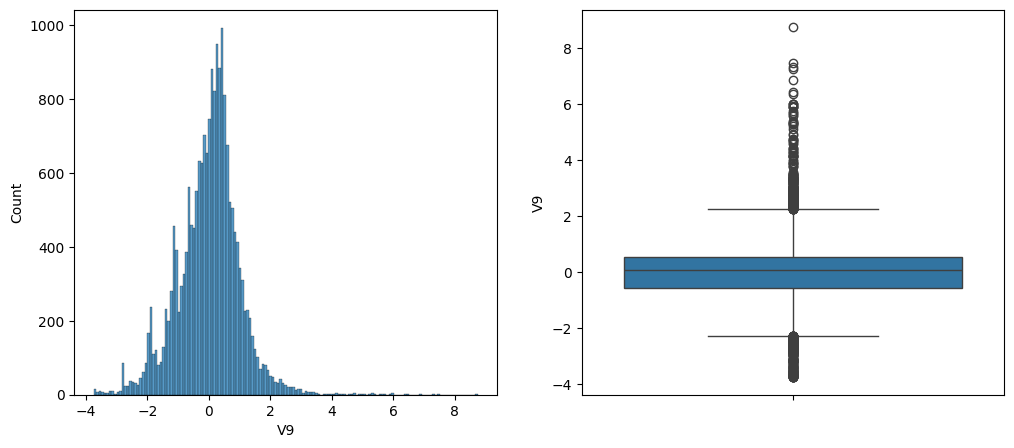

Histplot & Boxplot of V10


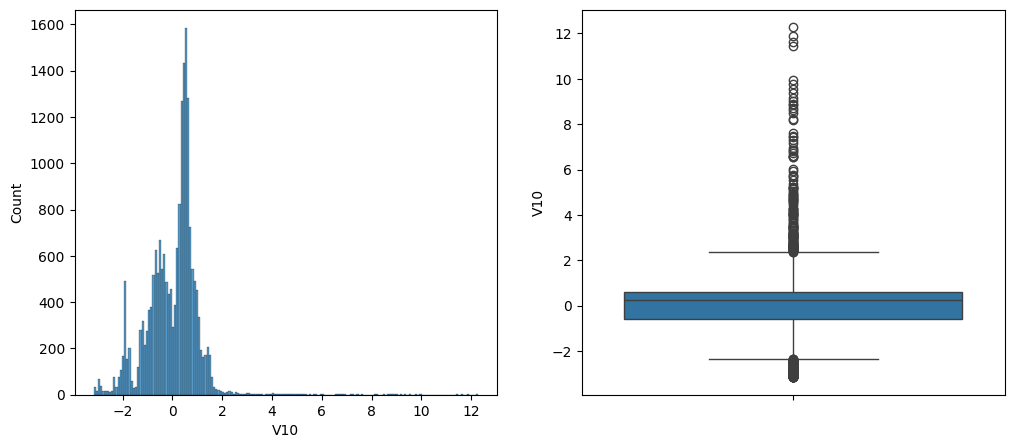

Histplot & Boxplot of V11


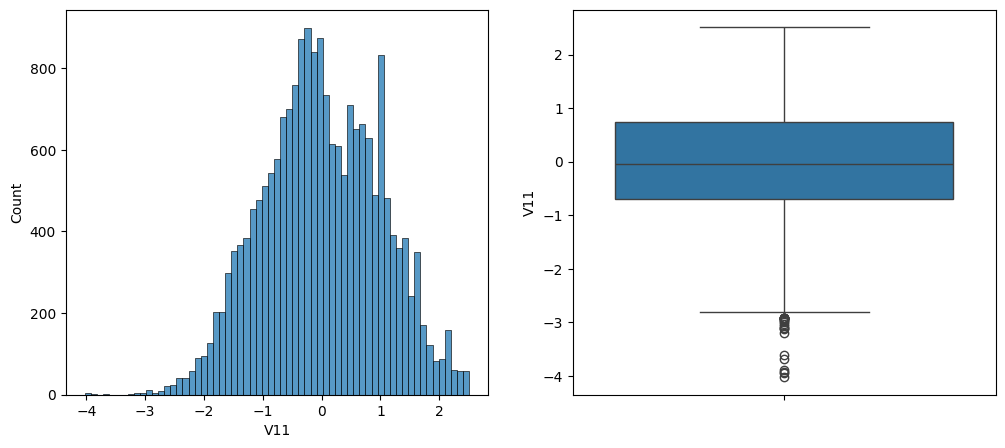

Histplot & Boxplot of V12


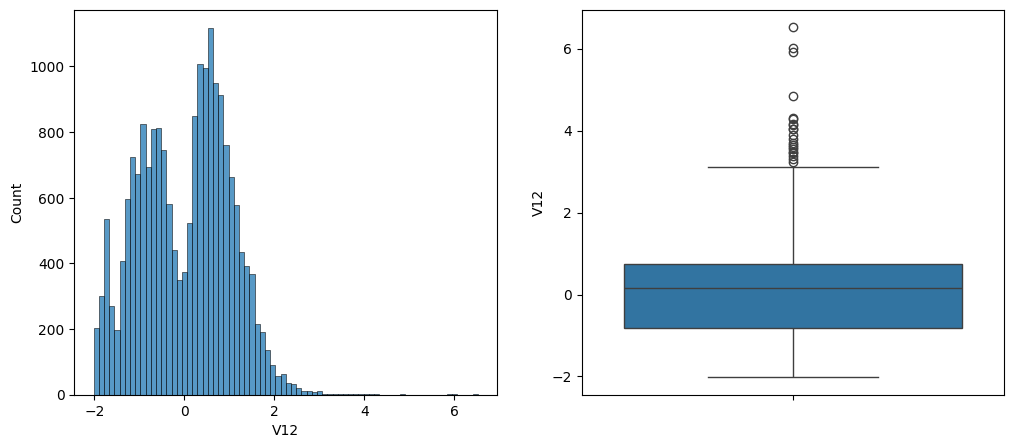

Histplot & Boxplot of V13


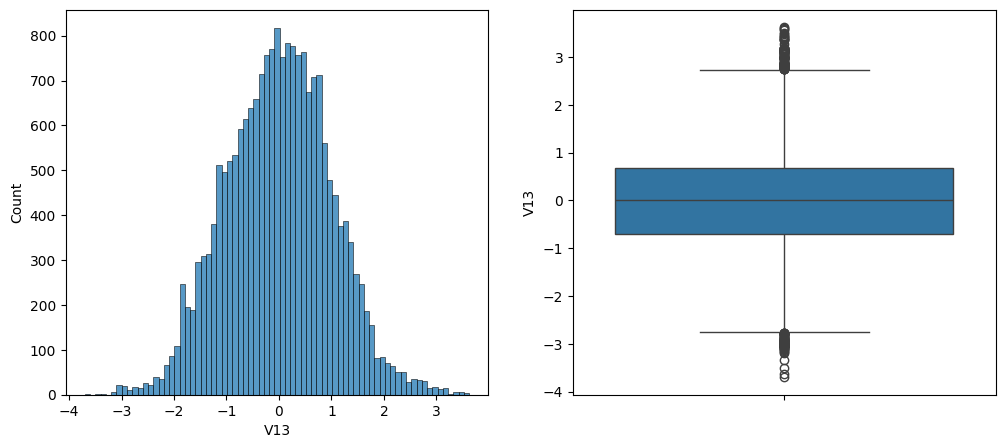

Histplot & Boxplot of V14


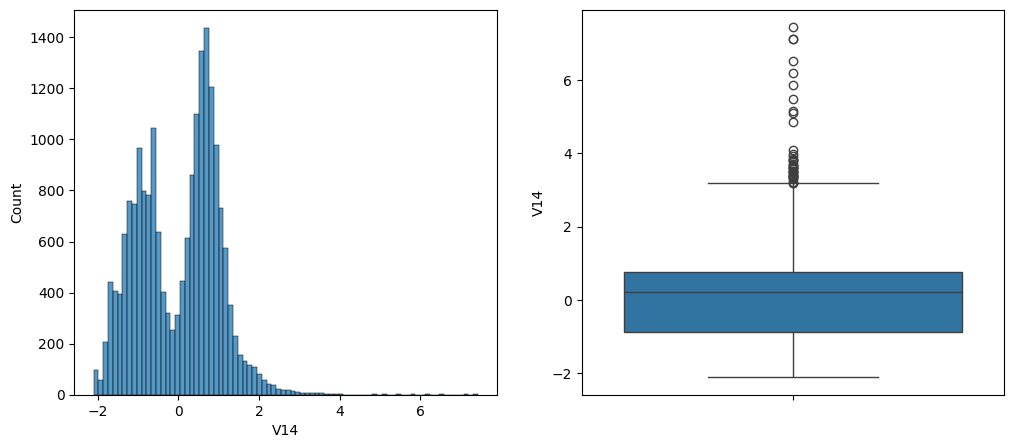

Histplot & Boxplot of V15


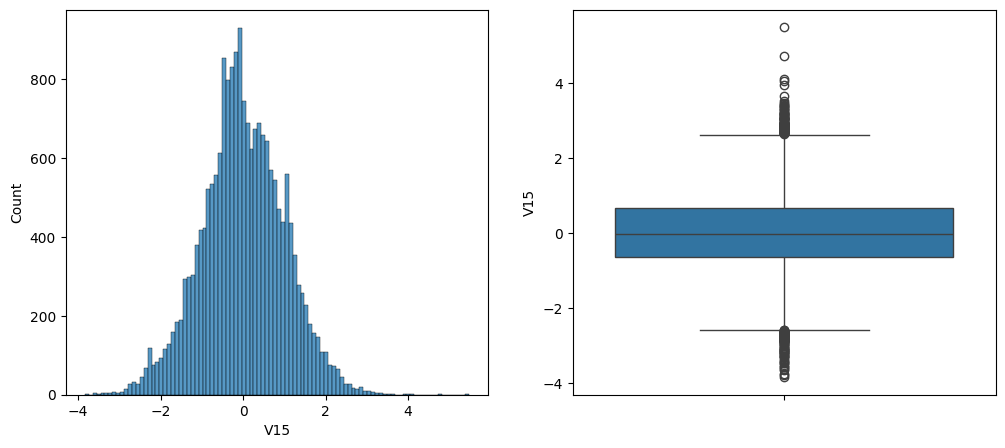

Histplot & Boxplot of V16


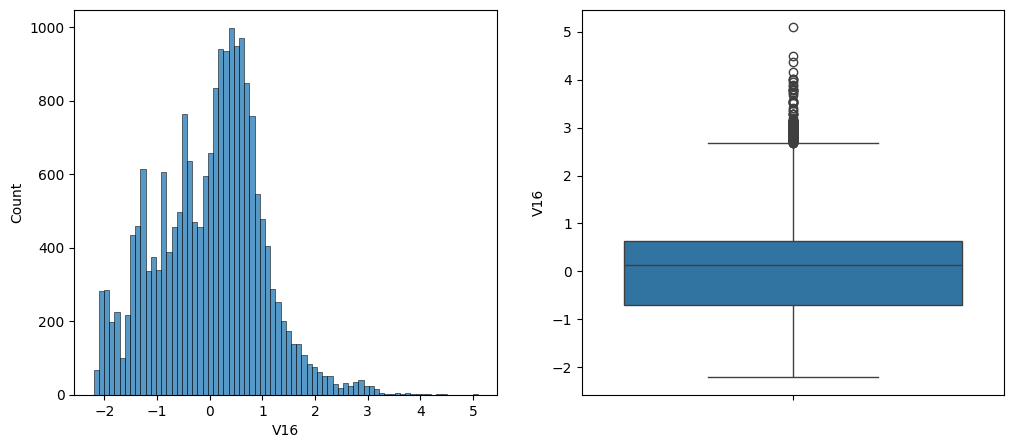

Histplot & Boxplot of V17


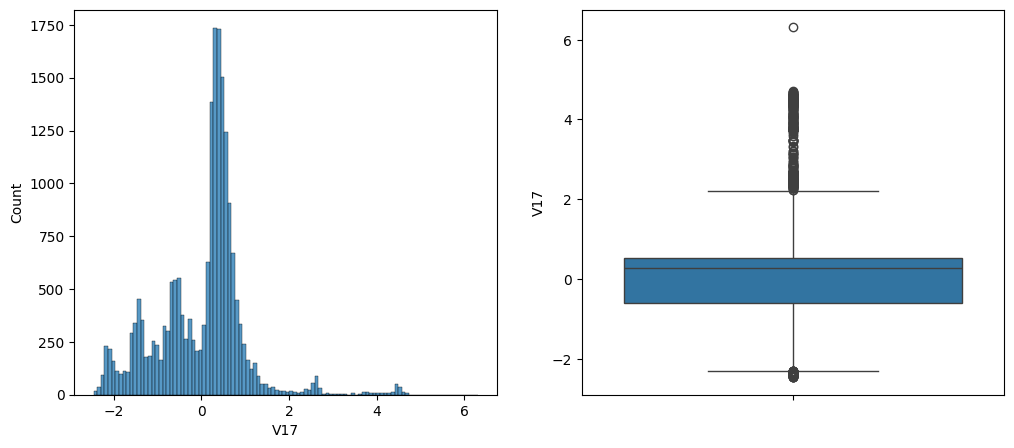

Histplot & Boxplot of V18


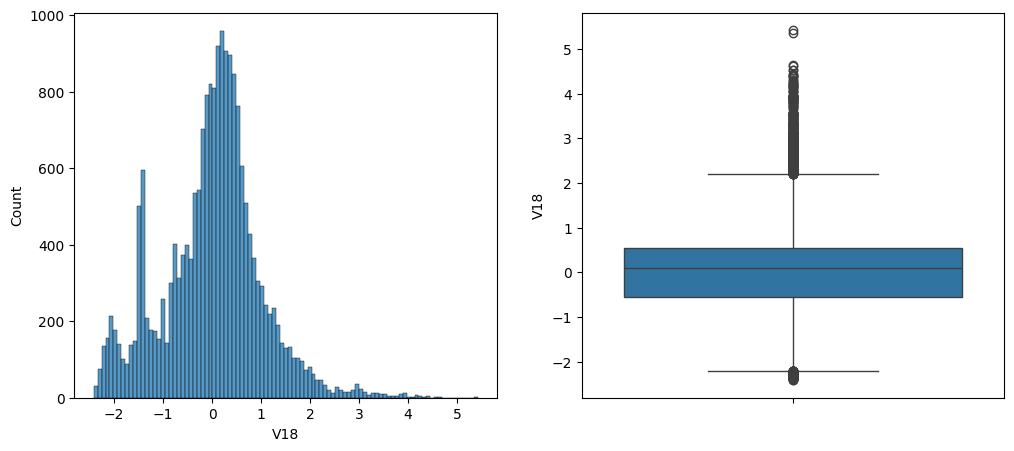

Histplot & Boxplot of V19


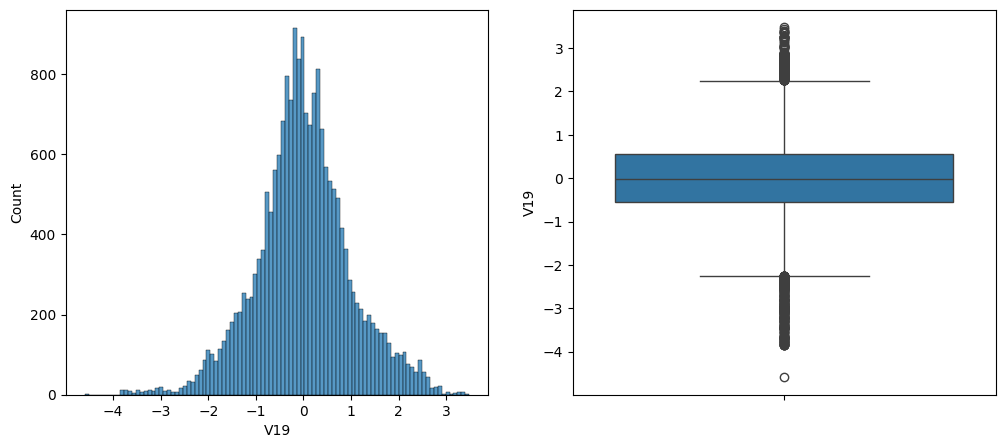

Histplot & Boxplot of V20


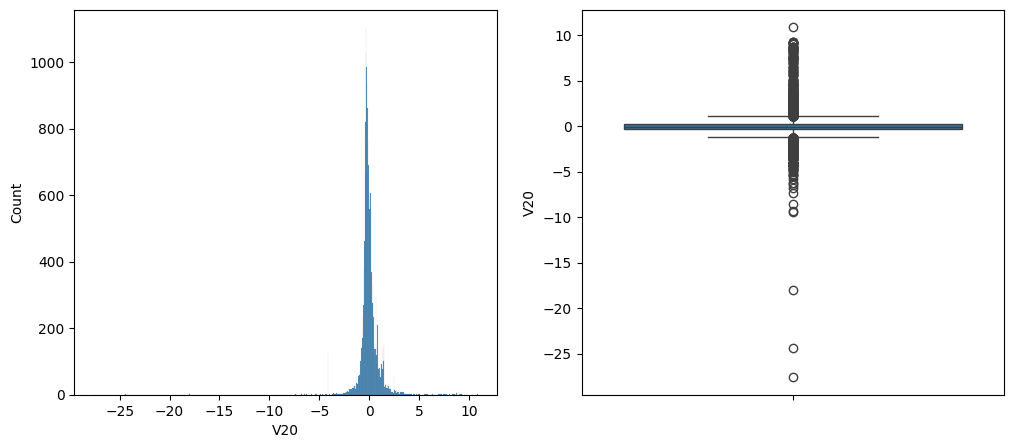

Histplot & Boxplot of V21


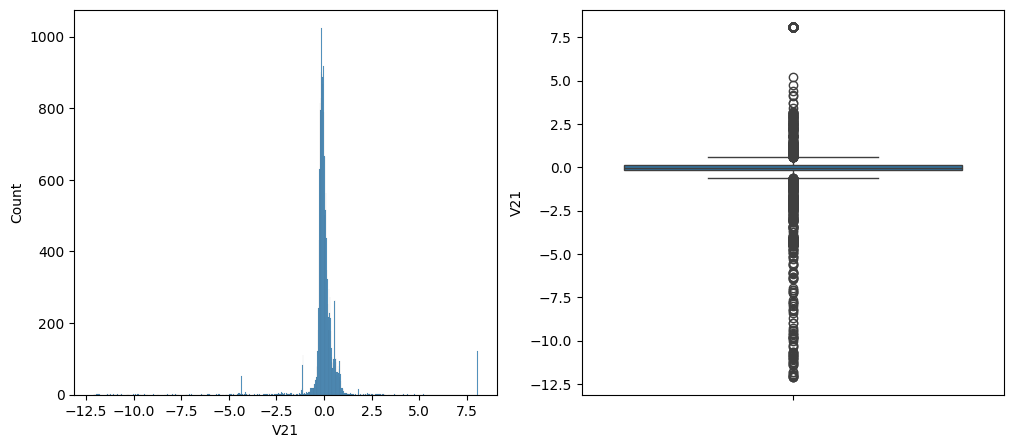

Histplot & Boxplot of V22


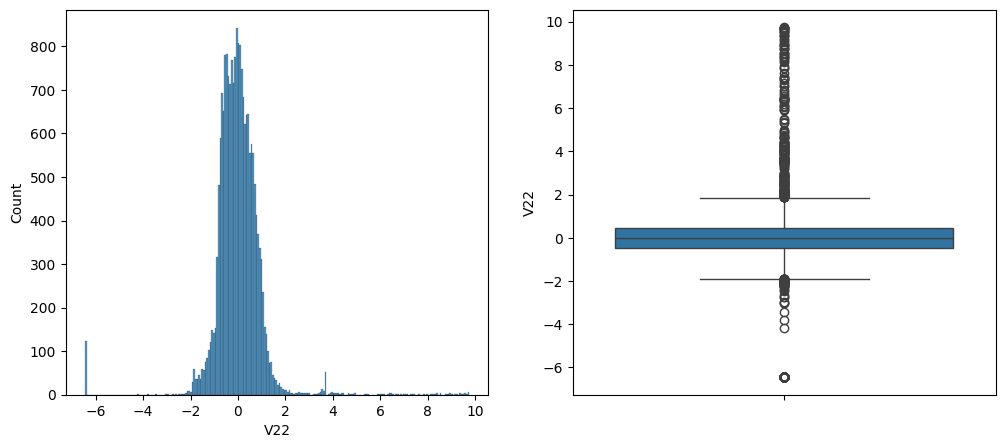

Histplot & Boxplot of V23


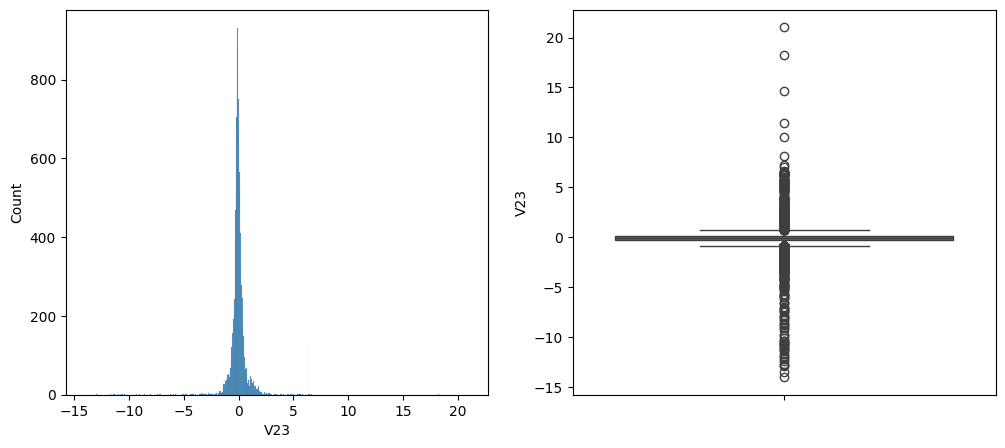

Histplot & Boxplot of V24


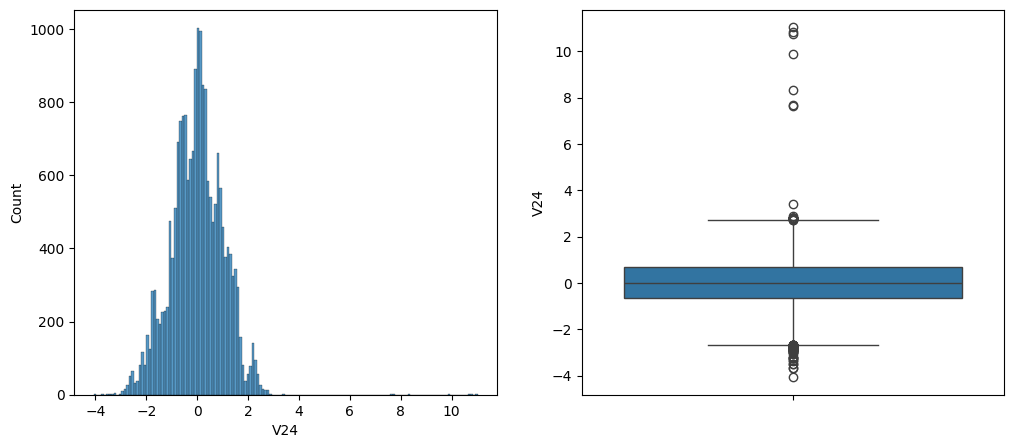

Histplot & Boxplot of V25


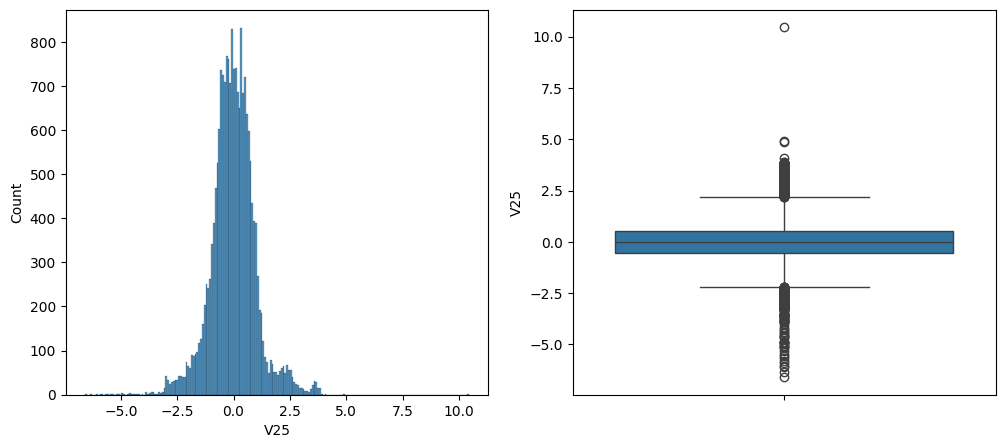

Histplot & Boxplot of V26


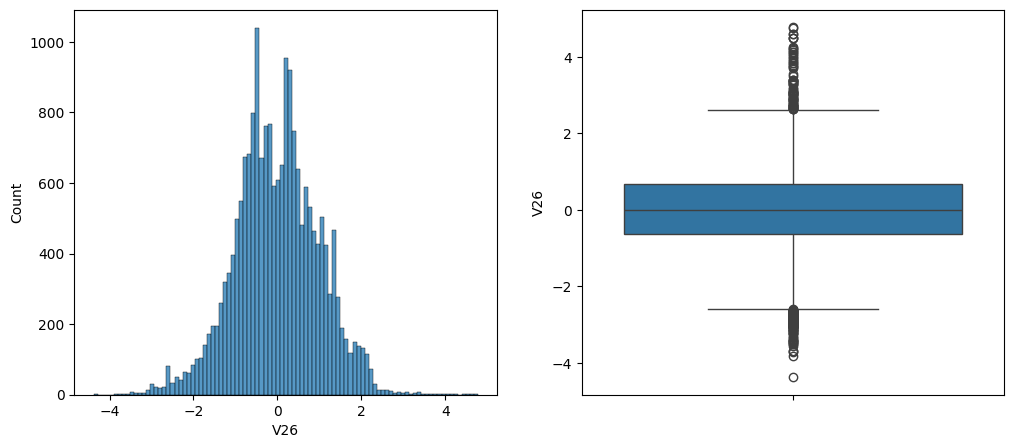

Histplot & Boxplot of V27


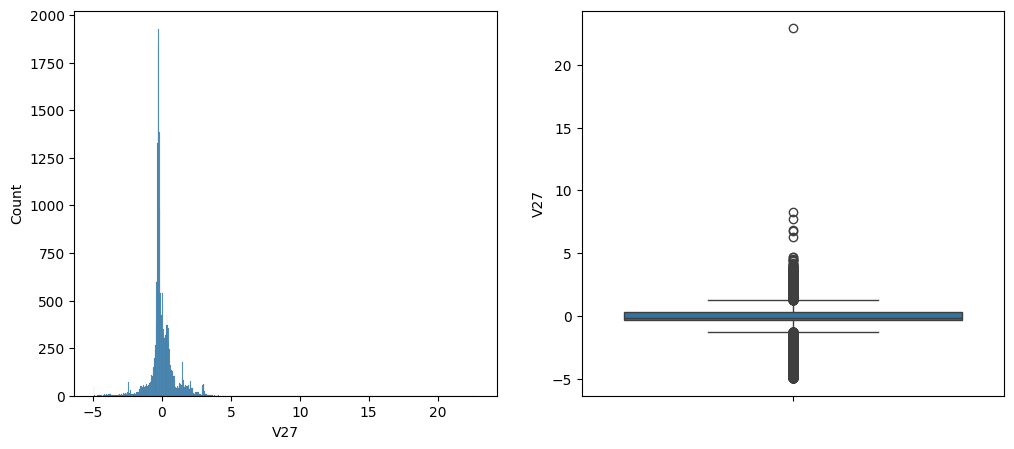

Histplot & Boxplot of V28


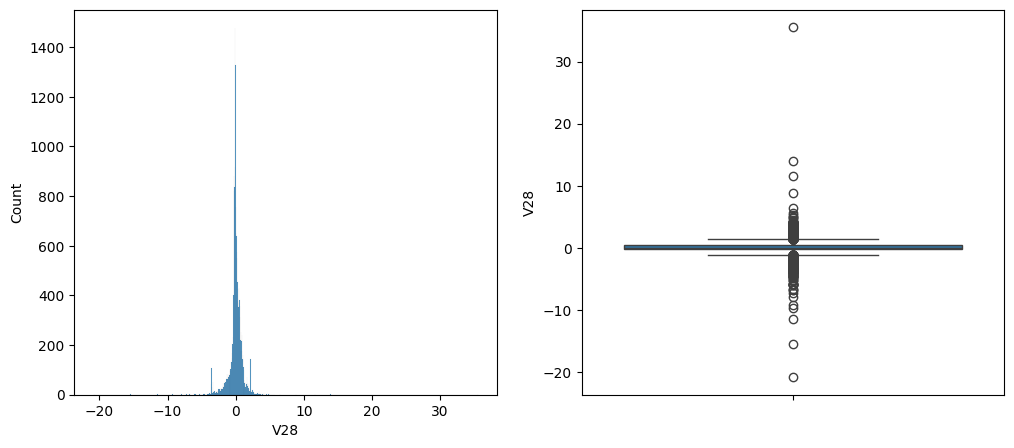

Histplot & Boxplot of Amount


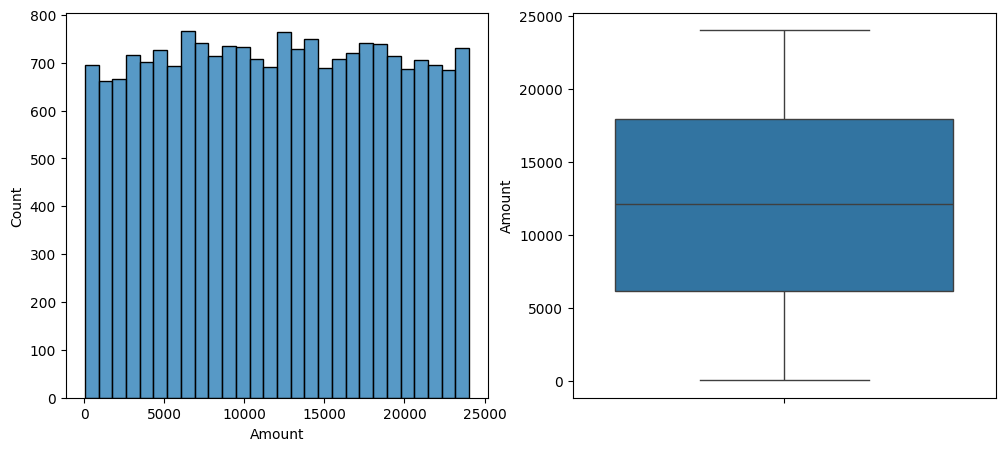

In [24]:
for col in df.columns.drop('Class'):
    print('Histplot & Boxplot of', col)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    ax1=sns.histplot(data=df, x=col)
    plt.subplot(1,2,2)
    ax2=sns.boxplot(data=df, y=col)
    plt.show()    

Except for variables *V1 and Amount*, the other variables have many outliers, and their distributions are non-standard. Therefore, we need to use RobustScaler method to scale the dataset.

In [12]:
X=df.drop('Class', axis=1)
y=df['Class']

In [13]:
y.value_counts()

0    10000
1    10000
Name: Class, dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.15)

In [15]:
X_train.shape, X_val.shape, X_test.shape

((13600, 29), (2400, 29), (4000, 29))

In [89]:
scaler=RobustScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#### MODEL TRAINING

Random Forest Model

In [ ]:
# Tunning parameters
grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
model_rf = RandomForestClassifier(n_jobs=-1) 
model_grid_rf = GridSearchCV(model_rf, grid_params, cv=5)
model_grid_rf.fit(X_train,y_train)
print('Random Forest')
print('Accuracy score:', model_grid_rf.best_score_)
print('Parameters:', model_grid_rf.best_params_)

Random Forest
Accuracy score: 0.992
Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:
model=RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)
print('Accuracy of Train: ',model.score(X_train, y_train))
print('Accuracy of Test: ',model.score(X_test, y_test))

Accuracy of Train:  1.0
Accuracy of Test:  0.99075


XGBoost Model

In [ ]:
# Tunning parameters
grid_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3,5,7],
    'subsample': [0.8, 1.0],
    'colsample_bytree' : [0.8, 1.0]
}

model_xg = XGBClassifier() 
grid_search_xg = GridSearchCV(estimator=model_xg, param_grid=grid_params, scoring='accuracy', cv=5)
grid_search_xg.fit(X_train, y_train)
print('XGBoost')
print('Accuracy score:', grid_search_xg.best_score_)
print('Parameters:', grid_search_xg.best_params_)

XGBoost
Accuracy score: 0.9959999999999999
Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [30]:
model=XGBClassifier(colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, subsample=1.0)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)
print('Accuracy of Train: ',model.score(X_train, y_train))
print('Accuracy of Test: ',model.score(X_test, y_test))

Accuracy of Train:  1.0
Accuracy of Test:  0.99525


The accuracy score of the training sets for both models is the same, but the accuracy score of the testing sets for the XGBoost model is higher than that of the Random Forest model. Therefore, we will use the XGBoost model as our final model.

### MODEL EVALUATION

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2019
           1       0.99      1.00      1.00      1981

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



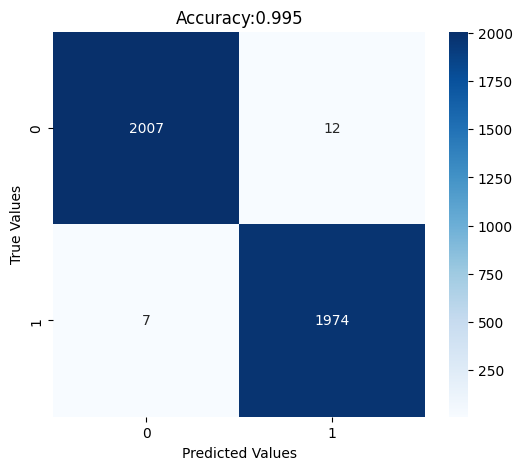

In [20]:
cm=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{model.score(X_test, y_test):.3f}')
plt.show()

The model accurately predicts 99.5% of the test cases. Out of 4,000 cases, there are 19 incorrect predictions: 12 cases that are not fraud but were predicted as fraud, and 7 cases that are actually fraud but were missed.

Model evaluation on training and testing sets

In [21]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)

In [22]:
# Training sets
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)

y_train_prob = model.predict_proba(X_train)[:,1]
train_precision_auc, train_recall_auc, train_threshold_auc = precision_recall_curve(y_train, y_train_prob)
train_auc_pr = auc(train_recall_auc, train_precision_auc)

print('Precision score of training sets:', train_precision)
print('Recall score of training sets:', train_recall)
print('AUC-PR score of training sets:', train_auc_pr)

Precision score of training sets: 1.0
Recall score of training sets: 1.0
AUC-PR score of training sets: 1.0


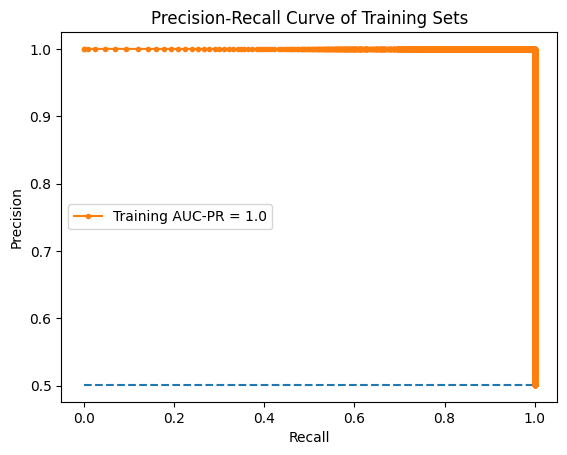

In [23]:
# Plot Precision-Recall Curve
ns=len(y_train[y_train==1])/len(y_train)
plt.plot([0,1], [ns,ns], linestyle='--' )
plt.plot(train_recall_auc, train_precision_auc, marker='.', label=f'Training AUC-PR = {train_auc_pr}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Training Sets')
plt.legend()
plt.show()

In [107]:
# R2 & Adjusted R2
train_r2 = r2_score(y_train, y_train_prob)
train_r2_adj = 1 - (1 - train_r2) * ((len(y_train) - 1) / len(y_train))
print('R2 of training sets:', train_r2)
print('Adjusted R2 of training sets:', train_r2_adj)

R2 of training sets: 0.9999839067459106
Adjusted R2 of training sets: 0.9999839079292382


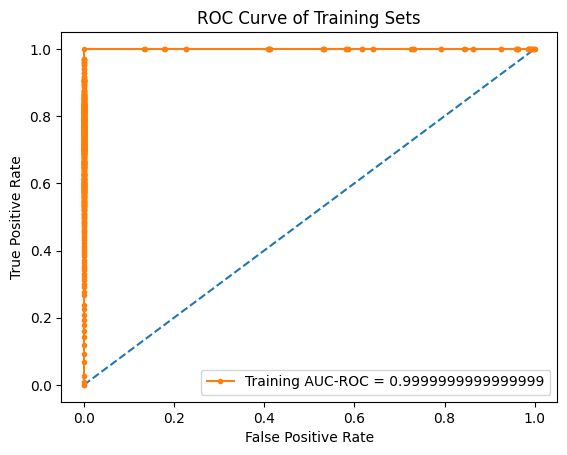

In [24]:
# AUC-ROC
train_fpr, train_tpr, train_threshold = roc_curve(y_train, y_train_prob)
train_auc_roc=roc_auc_score(y_train, y_train_prob)
# Plot ROC Curve
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(train_fpr, train_tpr, marker='.', label=f'Training AUC-ROC = {train_auc_roc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Training Sets')
plt.legend()
plt.show()

In [25]:
# Testing sets
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

y_test_prob = model.predict_proba(X_test)[:,1]
test_precision_auc, test_recall_auc, test_threshold_auc = precision_recall_curve(y_test, y_test_prob)
test_auc_pr = auc(test_recall_auc, test_precision_auc)

print('Precision score of testing sets:', test_precision)
print('Recall score of testing sets:', test_recall)
print('AUC-PR score of testing sets:', test_auc_pr)

Precision score of testing sets: 0.9939577039274925
Recall score of testing sets: 0.9964664310954063
AUC-PR score of testing sets: 0.9997358890318865


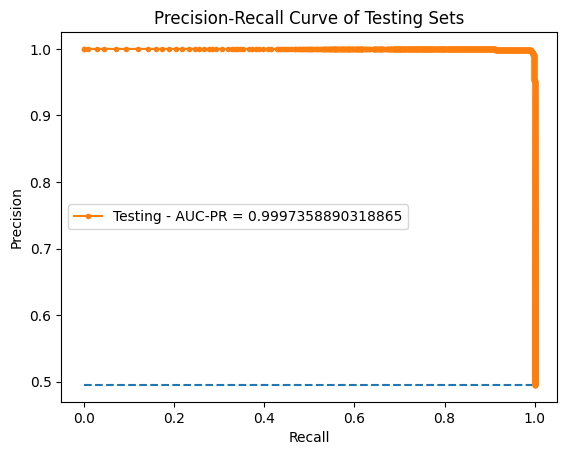

In [26]:
# Plot Precision-Recall Curve
ns=len(y_test[y_test==1])/len(y_test)
plt.plot([0,1], [ns,ns], linestyle='--')
plt.plot(test_recall_auc, test_precision_auc, marker='.', label=f'Testing - AUC-PR = {test_auc_pr}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Testing Sets')
plt.legend()
plt.show()


In [106]:
# R2 & Adjusted R2
test_r2 = r2_score(y_test, y_test_prob)
test_r2_adj = 1 - (1 - test_r2) * ((len(y_test) - 1) / len(y_test))
print('R2 of testing sets:', test_r2)
print('Adjusted R2 of testing sets:', test_r2_adj)

R2 of testing sets: 0.9836243391036987
Adjusted R2 of testing sets: 0.9836284330189228


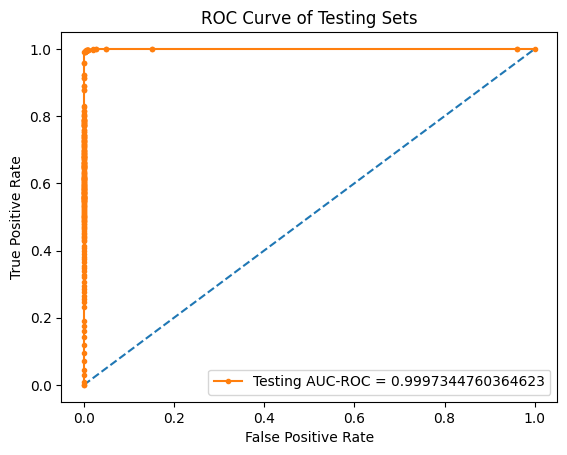

In [27]:
# AUC-ROC
test_fpr, test_tpr, test_threshold = roc_curve(y_test, y_test_prob)
test_auc_roc=roc_auc_score(y_test, y_test_prob)
# Plot ROC Curve
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(test_fpr, test_tpr, marker='.', label=f'Testing AUC-ROC = {test_auc_roc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Testing Sets')
plt.legend()
plt.show()

The model performs quite well on the training set, with metrics almost perfect, and also predicts well on the test set, with metrics just slightly lower than those on the training set

####  EVALUATE THE STABILITY OF THE MODEL

In [28]:
score=cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5)
print(score)
print(score.mean(), score.std())

[0.99522059 0.99669118 0.99411765 0.99007353 0.99669118]
0.9945588235294119 0.0024431246655641312


After 5 iterations, the Accuracy Score ranged from 0.99 to 0.996, with a low standard deviation of 0.002, indicating that the model is highly stable.

#### SAVE MODEL

In [97]:
pipeline=Pipeline(steps=[('Scaler', RobustScaler()),
                        ('XGBoost Model', XGBClassifier(colsample_bytree=1.0, learning_rate=0.3, max_depth=7, n_estimators=200, subsample=1.0))])

In [98]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Scaler', RobustScaler()),
                ('XGBoost Model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [99]:
joblib.dump(pipeline, 'Fraud_Detection_Model.pkl')
print('Model is saved!')

Model is saved!


In [100]:
loaded_model=joblib.load('Fraud_Detection_Model.pkl')
loaded_model

Pipeline(steps=[('Scaler', RobustScaler()),
                ('XGBoost Model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [101]:
y_val_pred=loaded_model.predict(X_val)

In [102]:
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

y_val_prob = model.predict_proba(X_val)[:,1]
val_precision_auc, val_recall_auc, val_threshold_auc = precision_recall_curve(y_val, y_val_prob)
val_auc_pr = auc(val_recall_auc, val_precision_auc)

print('Precision score of val sets:', val_precision)
print('Recall score of val sets:', val_recall)
print('AUC-PR score of val sets:', val_auc_pr)

Precision score of val sets: 0.990924092409241
Recall score of val sets: 0.9975083056478405
AUC-PR score of val sets: 0.9969595379983345


In [103]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1196
           1       0.99      1.00      0.99      1204

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400



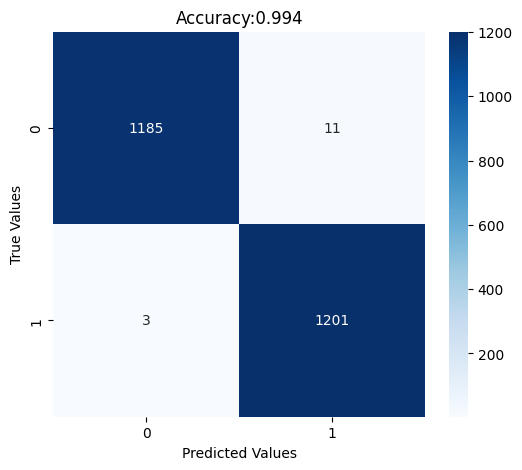

In [108]:
cm=confusion_matrix(y_val, y_val_pred)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title(f'Accuracy:{loaded_model.score(X_val, y_val):.3f}')
plt.show()

The model was saved and loaded to test on the validation sets and produced results as good as during training, with an accuracy of over 99%. Only 13 cases out of 2,400 were predicted incorrectly.